This notebook explores a few different potential models of the Milky Way

In [1]:
import agama

import arya
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import numpy as np

from astropy import coordinates as coord


In [2]:
from astropy.constants import G
# galpy_to_standard_force = 1/((2*np.pi*G *u.Msun / u.pc**2).to("km/Myr s"))
# print(galpy_to_standard_force)
# galpy_to_standard_force = galpy_to_standard_force.value

H0 = 67.74*u.km/u.s/u.Mpc
Ωm = 0.3
ρ_c = 3* H0**2 / (8*np.pi * G )
ρ200 = 200*ρ_c.to("Msun / kpc^3")


kms = u.km/u.s
Σ0 = u.Msun / u.pc**2

In [3]:
V0 = 207.4 # km / s
M0 = 1 # 1e10 Msun
R0 = 1 # kpc
T0 = 4.715e-3 # Gyr

In [4]:
#agama.setUnits(mass=M0*1e10, length=R0, time=T0 * 1e3)
agama.G

1.0

In [5]:
T_END = 10 / T0
times = np.linspace(0, T_END, 10_000)

In [6]:
def plot_orbit_x_y(o, **kwargs):
    times, pos = o
    plt.scatter(pos[:, 0], pos[:, 1], s=2, c=times, **kwargs)
    plt.gca().set_aspect(1)
    plt.xlabel("x / kpc")
    plt.ylabel("y / kpc")
    plt.show()


In [7]:
def plot_orbit_r_t(o, **kwargs):
    times, pos = o
    r = np.sqrt(np.sum(pos[:, 0:3] ** 2, axis=1) )
    plt.scatter(times * T0, r, c=times, s=2, **kwargs)
    
    print("peri : ", np.min(r))
    print("apo : ", np.max(r))
    plt.xlabel("time / Gyr")
    plt.ylabel("r / kpc")
    
    plt.show()


In [8]:
def plot_orbit_R_z(o, **kwargs):
    times, pos = o
    R = np.sqrt(np.sum(pos[:, 0:2] ** 2, axis=1) )
    z = pos[:, 2]
    plt.scatter(R, z, c=times, s=2, **kwargs)
    
    plt.xlim(0)
    plt.gca().set_aspect(1)
    plt.xlabel("R / kpc")
    plt.ylabel("z / kpc")
    plt.show()


In [9]:
def A_NFW(c):
    return (np.log(1+c) - c/(1+c))

def R200_NFW(M200):
    r = ( 3*M200 / (4*np.pi * 200*ρ_c))**(1/3)
    return r.to("kpc")

In [10]:
def Ms_NFW(M200, c):
    return M200 / A_NFW(c)  

In [11]:
R200_NFW(1.04*M0 * 1e10*u.Msun) / 12.5

<Quantity 3.68178142 kpc>

In [12]:
def find_M_c(Ms, Rs, c_i=13):
    c = c_i
    for i in range(100):
        M200 = Ms * A_NFW(c)
        Rv = R200_NFW(M200)
        c = (Rv/Rs).decompose()
    return c, M200

# Sky Positions

In [38]:
sculptor = coord.SkyCoord(
    ra=15.0183*u.degree, 
    dec= -33.7186*u.degree, 
    distance=83.2*u.kpc, 
    radial_velocity=111.4*kms,
    pm_ra_cosdec=0.099*u.mas/u.year, 
    pm_dec=-0.160*u.mas/u.year
)                 

In [36]:
dwarf_galaxy = sculptor
coord.galactocentric_frame_defaults.set("v4.0")

gc_frame = coord.Galactocentric()
dwarf_galaxy_gc = dwarf_galaxy.transform_to(gc_frame)
dwarf_galaxy_gc

print(dwarf_galaxy_gc.cartesian.xyz)
print(dwarf_galaxy_gc.velocity.d_xyz)

x = dwarf_galaxy_gc.cartesian
v = dwarf_galaxy_gc.velocity

dwarf_galaxy_gc = coord.Galactocentric(x=x.x, y=x.y, z=x.z,
    v_x=-v.d_x, v_y=-v.d_y, v_z=-v.d_z)
dwarf_galaxy_gc

[ -5.31808662  -9.45039696 -82.59317107] kpc
[ 19.47295342 159.28303792 -94.31315104] km / s


<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    (-5.31808662, -9.45039696, -82.59317107)
 (v_x, v_y, v_z) in km / s
    (-19.47295342, -159.28303792, 94.31315104)>

In [16]:
ic = np.concatenate([dwarf_galaxy_gc.cartesian.xyz.value / R0, dwarf_galaxy_gc.velocity.d_xyz.value / V0])
ic

array([ -5.31808662,  -9.45039696, -82.59317107,  -0.09389081,
        -0.76799922,   0.45474036])

In [17]:
gc_frame.galcen_v_sun

<CartesianDifferential (d_x, d_y, d_z) in km / s
    (12.9, 245.6, 7.78)>

in the case of sculptor, this results in a reversal in the sign of both proper motions.

In [19]:
def plot_pot(pot, z=0, **kwargs):
    Rs = np.linspace(0.1, 20, 100) * u.kpc
    z = z * u.kpc
    phis = pot(Rs, z)
    plt.plot(Rs, phis)

def plot_pot_2d(pot, R_max=20, z_max=5, R_min=0.001, res=500, **kwargs):
    plt.figure(figsize=(20, 7))
    Rs = np.linspace(R_min, R_max, res) * u.kpc
    zs = np.linspace(0, z_max, res) * u.kpc
    phis = [gp.evaluatePotentials(pot, Rs, z) for z in zs]
    plt.contourf(Rs, zs, phis, levels=round(np.sqrt(res)))
    plt.colorbar()
    plt.gca().set_aspect(1)
    plt.xlabel("R / kpc")
    plt.ylabel("z / kpc")
    
def plot_Vc(pot, R_max=60, R_min=0.01, res=300, **kwargs):
    Rs = np.logspace(np.log10(R_min), np.log10(R_max), res)  * u.kpc
    Vc = gp.calcRotcurve(pot, Rs, 0)
    plt.plot(Rs, Vc, **kwargs)
    plt.xlabel(r"$R$ / kpc")
    plt.ylabel(r"$V_{\rm circ} / \rm km\,s^{-1}$")
    
def plot_Kz(pot, R_max=9, R_min=4, z = 1.1*u.kpc, res=1000, **kwargs):
    Rs = np.linspace(R_min, R_max, res) * u.kpc
    Kz = [ -galpy_to_standard_force * gp.evaluatezforces(pot, r, z).value for r in Rs]
    plt.plot(Rs,Kz, **kwargs)
    plt.yscale("log")
    plt.ylabel(r"Kz / ($2\pi\ G\rm\ M_\odot / pc^2$)")
    plt.xlabel(r"$R$ / kpc")

## Agama setup

# loading potentials

In [20]:
EP2020 = agama.Potential(file="../potentials/EP2020.ini")

In [48]:
n = EP2020[3]

In [57]:
EP2020.Rperiapo([-5.31809, -9.4504, -82.5932, -0.0938908, -0.767999, 0.45474])

array([ 52.22705867, 102.71717342])

In [21]:
gp_MW14 = agama.Potential(file="../potentials/galpy_2014.ini")

In [22]:
mm11 = agama.Potential(file="../potentials/mcmillan11.ini")
mm17 = agama.Potential(file="../potentials/mcmillan17.ini")
bt08 = agama.Potential(file="../potentials/BT08.ini")
piffl14 = agama.Potential(file="../potentials/piffl_14.ini")


In [23]:
def plot_orbit_in_pot(pot):
    o = agama.orbit(ic=ic, time=T_END, potential=pot, trajsize=1000)
    
    
    plot_orbit_r_t(o)
    plot_orbit_R_z(o)
    #plot_orbit_x_y(o)

peri :  53.030727
apo :  101.98627


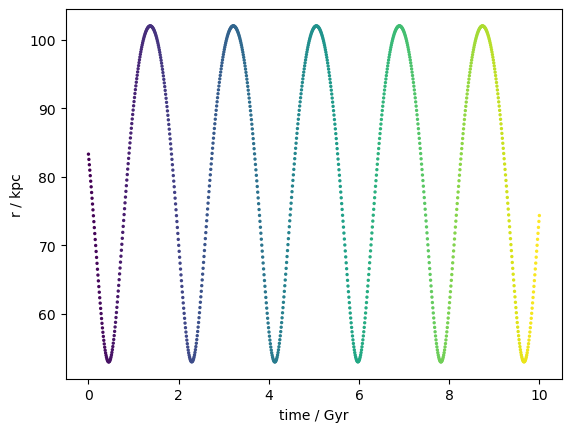

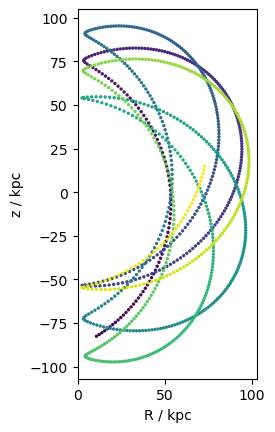

In [24]:
plot_orbit_in_pot(EP2020)

peri :  51.30294
apo :  99.611435


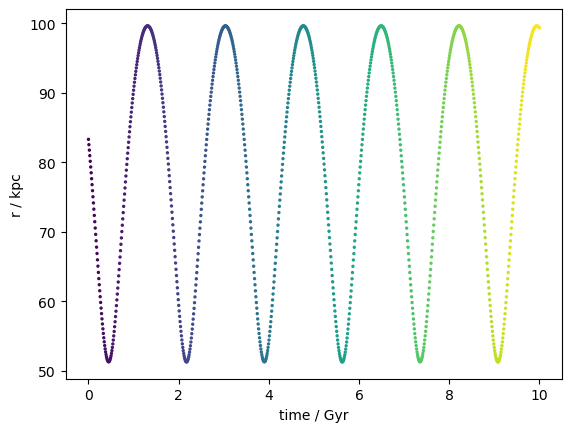

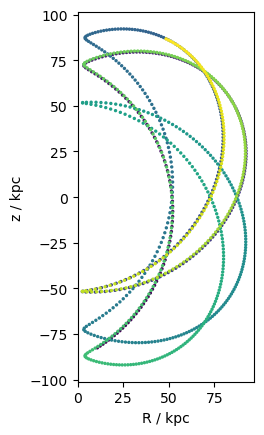

In [25]:
plot_orbit_in_pot(mm11)

peri :  53.18498
apo :  102.101295


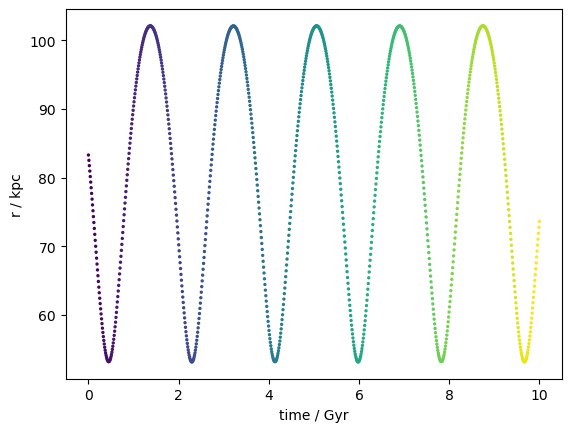

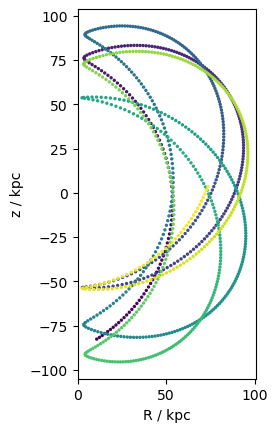

In [26]:
plot_orbit_in_pot(mm17)

peri :  64.95615
apo :  143.16014


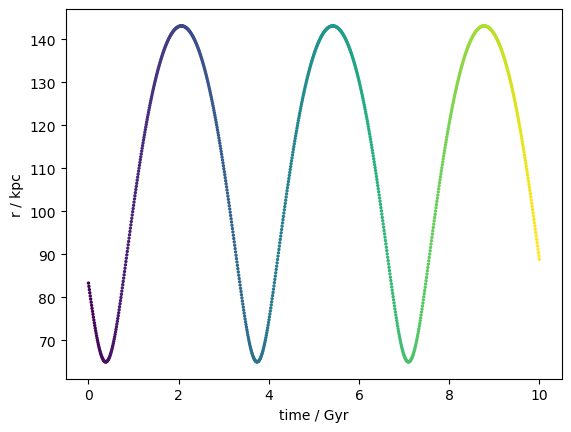

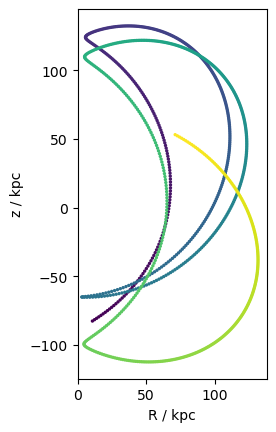

In [27]:
plot_orbit_in_pot(gp_MW14)

peri :  60.70833
apo :  119.44064


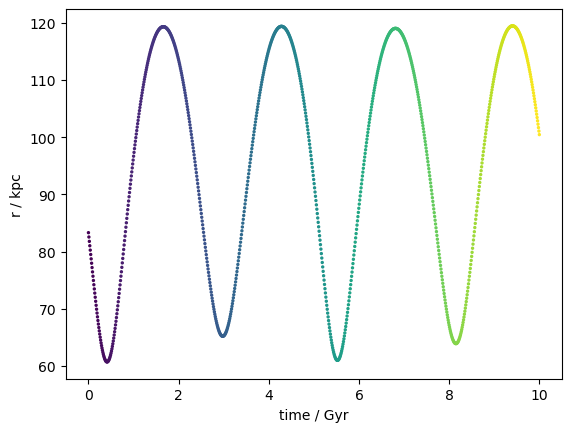

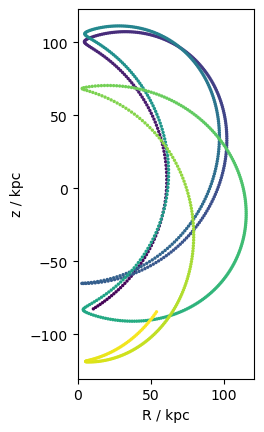

In [28]:
plot_orbit_in_pot(bt08)

peri :  51.241028
apo :  100.66738


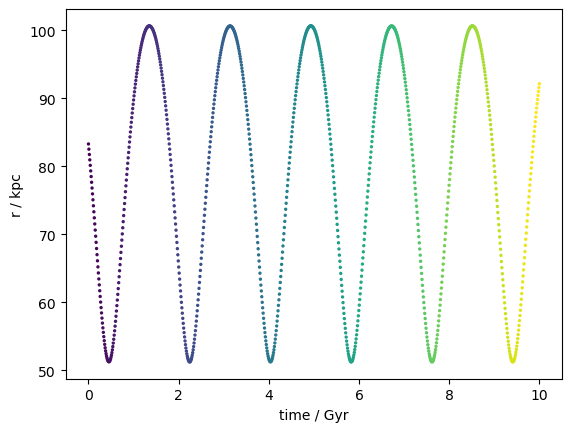

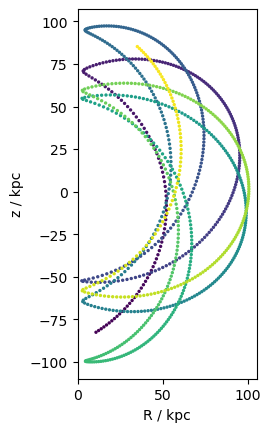

In [29]:
plot_orbit_in_pot(piffl14)

In [33]:
EP2020.enclosedMass(100)

85.27201199527559

In [30]:
R200_NFW(M200) / c

NameError: name 'M200' is not defined

In [ ]:
galpy14_bulge = gp.PowerSphericalPotentialwCutoff(amp=1*M0/u.kpc**3, alpha=1.8, rc=1.9*u.kpc)
galpy14_bulge *= (0.5*M0 / galpy14_bulge.mass(60)).value
galpy14_disk = MN75(amp=6.8*M0, a=3*u.kpc, b=0.28*u.kpc)

galpy14_halo = NFW(amp=Ms, a=16*u.kpc)
galpy14 = galpy14_bulge + galpy14_disk + galpy14_halo
galpy14_heavy = galpy14_bulge + galpy14_disk + 2*galpy14_halo

In [ ]:
galpy14_halo.mass(60*u.kpc) + galpy14_disk.mass(60*u.kpc) + galpy14_bulge.mass(60*u.kpc)

In [ ]:
galpy14_halo.mass(16*u.kpc * c)

In [ ]:
galpy14_bulge.mass(10)

In [ ]:
plot_Vc(galpy14, R_max=32)
#plot_Vc(galpy14_heavy, R_max=32)

plot_Vc(galpy14_bulge, R_max=32)
plot_Vc(galpy14_disk, R_max=32)
plot_Vc(galpy14_halo, R_max=32)

In [ ]:
def mcmillan_bulge_rho(R, z):
    α=1.8
    r_0 = 0.075/Rgp # kpc
    r_c = 2.1/Rgp # kpc
    q = 0.5
    
    x = np.sqrt(R**2 + (z/q)**2)
    return  1*u.Msun/u.pc**3 / (1 + x/r_0)**α * np.exp(-(x/r_c)**2) 

mcmillan_bulge_unnorm = gp.SCFPotential.from_density(mcmillan_bulge_rho, N=40, symmetry="axisymmetric", a=0.5/Rgp, L=20)


In [ ]:
A_mcmillan_bulge = (mcmillan_bulge_rho(0.5/Rgp, 0) / mcmillan_bulge_unnorm.dens(0.5*u.kpc, 0*u.kpc)).value


In [ ]:
thetas = [0, np.pi/3, np.pi/2, np.pi*2/3, np.pi]
Rs = np.linspace(0.01, 10, 1000) * u.kpc
# test approximation
for theta in thetas:
    rs = Rs * np.cos(theta)
    zs = Rs*np.sin(theta)
    plt.plot(Rs,  A_mcmillan_bulge * mcmillan_bulge_unnorm.dens(rs, zs))
    plt.plot(Rs,  mcmillan_bulge_rho(rs/u.kpc/Rgp, zs/u.kpc/Rgp))

    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-10)
    plt.show()

In [ ]:
def mcmillan_disk(sigma, r, z):
    return ExpDisk(amp=sigma / z / 2, hr=r, hz=z, )

In [ ]:
mcmillan2011_thin = mcmillan_disk(816.6*Σ0, 2.90*u.kpc, 0.3*u.kpc)
mcmillan2011_thick = mcmillan_disk(208*Σ0, 3.31*u.kpc, 0.9*u.kpc)
mcmillan2011_bulge = A_mcmillan_bulge * 95.6 * mcmillan_bulge_unnorm 


rh = 20.2 * u.kpc
rho_h = 0.00846*u.Msun/u.pc**3
Ms = rho_h * 4*np.pi * rh**3 
mcmillan2011_halo = NFW(amp=Ms, a=rh)

mcmillan2011 = mcmillan2011_bulge + mcmillan2011_halo + mcmillan2011_thick + mcmillan2011_thin

In [ ]:
for theta in thetas:
    rs = Rs * np.cos(theta)
    zs = Rs*np.sin(theta)
    plt.plot(Rs, mcmillan2011_bulge(rs, zs))
    plt.plot(Rs, (EP2020_bulge)(rs, zs))
    plt.show()

## Chaos

In [ ]:
def mcmillan_gas_rho_model(z_d, R_m, R_d):
    def inner(R, z, phi=0):
        return  1 /(4*z_d) * np.exp(-R_m/R - R / R_d) * np.cosh(z/(2*z_d))**-2
    return inner


h1_rho = mcmillan_gas_rho_model(0.085, 4, 7)
h2_rho = mcmillan_gas_rho_model(0.045, 12, 1.5)

# h1_rho = mcmillan_gas_rho_model(1, 4/7, 1)
# h2_rho = mcmillan_gas_rho_model(1, 7/1.5, 1)


In [ ]:
rh = 4
rd = 7
r_z = 0.085


def S(x):
    x = np.array(x)
    return np.where(x<=0, np.nan, np.exp( -rd/x - x/rh))

def hz(z):
    x = z / r_z
    return np.cosh(x)**-2

    
def Hz(z):

    x = z / r_z
    return r_z**2 * (2*x + np.log(np.exp(-2*x) + 1))

def dHz(z):

    x = z/r_z
    return r_z*(-2*np.exp(-2*x)/(np.exp(-2*x) + 1) + 2)

def dSdz(x):
    x = np.array(x)

    return np.where(x<=0, np.nan, -(1/rh - rd/x**2)*np.exp(-rd/x - x/rh))

def dS2dz2(x):
    x = np.array(x)

    return np.where(x<=0, np.nan,
                    (1/rh - rd/x**2)**2*np.exp(-rd/x - x/rh) - 2*rd*np.exp(-rd/x - x/rh)/x**3

                   )

In [ ]:
mcmillan_h1_unnorm = gp.DiskSCFPotential(dens=h1_rho, N=20,  L=20, a=7,  
      Sigma={'type':'exp','h':1, 'Rhole':4/7},
      hz={'type':'sech2','h':0.085},
        )

In [ ]:
mcmillan_h2_unnorm = gp.DiskSCFPotential(dens=h2_rho, N=20,  L=20, a=1, 
      Sigma={'type':'exp','h':1, 'Rhole':12/1.5},
      hz={'type':'sech2','h':0.045},
        )

In [ ]:
h1_rho(8, 0, 0)

In [ ]:
A_mcmillan_h1 = (h1_rho(3, 0, 0) / mcmillan_h1_unnorm.dens(3*u.kpc, 0, 0*u.kpc))
A_mcmillan_h2 = (h2_rho(3, 0, 0) / mcmillan_h2_unnorm.dens(3*u.kpc, 0, 0*u.kpc))

In [ ]:
zs = [0, 0.5, 1, 3, 10, 100] *u.kpc* 0.085
# test approximation
for z in zs:
    plt.plot(Rs,  A_mcmillan_h1 * mcmillan_h1_unnorm.dens(Rs, z))
    plt.plot(Rs,  h1_rho(Rs.value, z.value, 3))
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-10)
    plt.show()

In [ ]:
zs = [0, 0.5, 1, 3, 10, 100] * u.kpc
# test approximation
for z in zs:
    plt.plot(Rs,  A_mcmillan_h2 * mcmillan_h2_unnorm.dens(Rs, z))
    plt.plot(Rs,  h2_rho(Rs.value, z.value, 3))
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-10)
    plt.show()

In [ ]:
A_mcmillan_h1 = (h1_rho(3, 0, 0) / mcmillan_h1_unnorm.dens(3*u.kpc, 0, 0*u.kpc))
A_mcmillan_h2 = (h2_rho(3, 0, 0) / mcmillan_h2_unnorm.dens(3*u.kpc, 0, 0*u.kpc))

## normal

In [ ]:
mcmillan2017_bulge = A_mcmillan_bulge * 95.6 * mcmillan_bulge_unnorm 
# mcmillan2017_h1 = 53.1*A_mcmillan_h1 * mcmillan_h1_unnorm
# mcmillan2017_h2 = 2380*A_mcmillan_h2 * mcmillan_h2_unnorm

mcmillan2017_h1 = gp.MN3ExponentialDiskPotential(amp=1/3 *53.1*Σ0/(0.085*u.kpc), hr=7*u.kpc, hz=0.085*u.kpc)
mcmillan2017_h2 = gp.MN3ExponentialDiskPotential(amp=1/56 *2380*Σ0/(0.045*u.kpc), hr=1.5*u.kpc, hz=0.045*u.kpc)

mcmillan2017_h1b = gp.RazorThinExponentialDiskPotential(amp=35.7*Σ0, hr=7*u.kpc)
mcmillan2017_h2b = gp.RazorThinExponentialDiskPotential(amp=11.9*Σ0, hr=1.5*u.kpc)


mcmillan2017_thin = mcmillan_disk(886.7*Σ0, 2.53*u.kpc, 0.3*u.kpc)
mcmillan2017_thick = mcmillan_disk(156*Σ0, 3.38*u.kpc, 0.9*u.kpc)


rh = 18.6 * u.kpc
rho_h = 0.0093*u.Msun/u.pc**3
Ms = rho_h * 4*np.pi * rh**3 
mcmillan2017_halo = NFW(amp=Ms, a=rh)

mcmillan2017 = (
    mcmillan2017_bulge 
    + mcmillan2017_halo 
    + mcmillan2017_thick 
    + mcmillan2017_thin 
    + mcmillan2017_h1
    + mcmillan2017_h2
)

mcmillan2017_nogas = (
    mcmillan2017_bulge 
    + mcmillan2017_halo 
    + mcmillan2017_thick 
    + mcmillan2017_thin 
)



In [ ]:
mcmillan2017_bulge.mass(100*u.kpc)

In [ ]:
(2*np.pi * 886.7*Σ0 * ( 2.53*u.kpc)**2).to("Msun")

In [ ]:
0.862 + 3.566 + 1.119 # stellar mass is correct

In [ ]:
mcmillan2017_halo.dens(8.2*u.kpc, 0)

In [ ]:
gp.evaluatezforces(mcmillan2017, 8.2*u.kpc, z=1.1*u.kpc) * galpy_to_standard_force

In [ ]:
sum([a.mass(100*u.kpc) for a in mcmillan2017])

In [ ]:
(np.pi * 2 * (156*Σ0) * (3.38*u.kpc)**2).to("Msun")

In [ ]:
mcmillan2017_thick.mass(1000)

In [ ]:
(2*np.pi * 53.1*Σ0 * (7*u.kpc)**2).to("Msun")

In [ ]:
mcmillan2017_h1.mass(50*u.kpc)

In [ ]:
mcmillan2017_h2.mass(10*u.kpc)

In [ ]:
mcmillan2017_bulge.mass(10000*u.kpc)

In [ ]:
mcmillan2017_h1b.mass(1000)

In [ ]:
mcmillan2017_h2b.mass(10000)

In [ ]:
Rs = np.linspace(0, 20, 1000)*u.kpc
plt.plot(Rs, mcmillan2017_h1.dens(Rs, 0*u.kpc))
plt.plot(Rs, mcmillan2017_h2.dens(Rs, 0*u.kpc))

plt.yscale("log")

In [ ]:
plot_Vc(mcmillan2017, label="thick")
plot_Vc(mcmillan2017_nogas, label="thick")


In [ ]:
plot_Vc(mcmillan2017_thick, label="thick")
plot_Vc(mcmillan2017_thin, label="thin")


plot_Vc(mcmillan2017_h1, label="h1")
plot_Vc(mcmillan2017_h1b, )

plot_Vc(mcmillan2017_h2,label="h2")
arya.Legend(loc=-1)


In [ ]:
Mp = 2.32e7*u.Msun
pouliasis17_bulge = Plummer(amp=460*Mp, b=0.3*u.kpc)
pouliasis17_thin = MN75(amp=1700*Mp, a=5.3*u.kpc, b=0.25*u.kpc)
pouliasis17_thick = MN75(amp=1700*Mp, a=2.6*u.kpc, b=0.8*u.kpc)
ah = 14*u.kpc
Mh = 6000*Mp
pouliasis17_halo = 2*NFW(amp=Mh, a=ah) + gp.TwoPowerSphericalPotential(alpha=0, beta=2, amp=Mh, a=ah)

pouliasis17 = pouliasis17_bulge + pouliasis17_thin + pouliasis17_thick + pouliasis17_halo

In [ ]:
pouliasis17b_thin = MN75(amp=1600*Mp, a=4.8*u.kpc, b=0.25*u.kpc)
pouliasis17b_thick = MN75(amp=1700*Mp, a=2.0*u.kpc, b=0.8*u.kpc)
ah = 14*u.kpc
Mh = 9000*Mp
pouliasis17b_halo = 2*NFW(amp=Mh, a=ah) + gp.TwoPowerSphericalPotential(alpha=0, beta=2, amp=Mh, a=ah)

pouliasis17b = pouliasis17b_thin + pouliasis17b_thick + pouliasis17b_halo

builds on pouliasis but with NFW halo and more recent (cephied) data. Very close to galpy.

In [ ]:
R200_NFW(M200) / c

In [ ]:
M200 = 66.3*M0
c = 12.36
Ms = Ms_NFW( M200, c)

Rs = 14.45*u.kpc
Ms

In [ ]:
find_M_c(Ms, Rs)

In [ ]:
M200 = 6.749*M0
c = 12.7988
Ms = Ms_NFW(M200, c)

In [ ]:
Ms

In [ ]:
ablimit_c = {
    "halo": NFW(amp=Ms, a=Rs),
    "disk": pouliasis17_thick + pouliasis17_thin,
    "bulge": pouliasis17_bulge,
}

ablimit20a = [val for key, val in ablimit_c.items()]




In [ ]:
M200 = 82.2*M0
c = 13.04
Ms = Ms_NFW(M200, c)
ablimit_b_comp = {
    "halo": NFW(amp=Ms, a=14.71*u.kpc),
    "disk": pouliasis17_thick + pouliasis17_thin,
    "bulge": pouliasis17_bulge,
}

ablimit20b = [val for key, val in ablimit_b_comp.items()]


In [ ]:
R200_NFW(M200) / c

In [ ]:
plot_Vc(ablimit_c["halo"])
plot_Vc(galpy14_halo)

In [ ]:
plot_Vc(ablimit_b_comp["halo"])
plot_Vc(1.2*galpy14_halo)

In [ ]:
4*np.pi * M0 / (207.0*u.kpc)**3

In [ ]:
shen22_halo = gp.PowerSphericalPotential(amp=0.2275*M0, r1=1*u.kpc, alpha=2+0.43)


c=12
R200=207*u.kpc
Ms = Ms_NFW(105*M0, c) # is 95 in paper but not described well...
shen22_halo_b = NFW(amp=Ms, a=R200/c)

In [ ]:
conv.mass_in_1010msol(vo=Vgp, ro=Rgp)

In [ ]:
shen22_halo.mass(250*u.kpc) / M0

In [ ]:
shen22_halo_b.mass(R200) 

In [ ]:
shen22_halo.mass(10*u.kpc) / M0

In [ ]:
shen22_halo.mass(100*u.kpc) / M0

In [ ]:
shen22_halo.mass(250*u.kpc) / M0

In [ ]:
Rs = np.linspace(10, 250, 1000) * u.kpc

In [ ]:
plt.plot(Rs, [shen22_halo.mass(R) / M0 for R in Rs])
plt.plot(Rs, [shen22_halo_b.mass(R) / M0 for R in Rs])

In [ ]:
plot_Vc(shen22_halo, R_min=10)
plot_Vc(galpy14)
plot_Vc(shen22_halo_b, R_min=10)

In [ ]:
nitschai_halo = gp.TwoPowerTriaxialPotential(amp=41.1*M0, alpha=1.53, beta=3, a=16.8*u.kpc, c=1.14)
nitschai_halo_b = gp.TwoPowerSphericalPotential(amp=44.1*M0, alpha=1.53, beta=3, a=16.8*u.kpc)

In [ ]:
Mh = nitschai_halo.mass(8.2*u.kpc)

In [ ]:
nitschai_halo.dens(8.2*u.kpc, 0*u.kpc)

In [ ]:
Mh / (Mh + mcmillan2017_halo.mass(8.2*u.kpc) + mcmillan2017_thick.mass(8.2*u.kpc) +  mcmillan2017_thin.mass(8.2*u.kpc))

In [ ]:
plot_Vc(nitschai_halo)
plot_Vc(nitschai_halo_b)

plot_Vc(EP2020_halo)

In [ ]:
nitschai = nitschai_halo + mcmillan2017_bulge + mcmillan2017_thick + mcmillan2017_thick + mcmillan2017_h1 + mcmillan2017_h2
nitschai_b = nitschai_halo_b + mcmillan2017_bulge + mcmillan2017_thick + mcmillan2017_thick + mcmillan2017_h1 + mcmillan2017_h2

In [ ]:
mcmillan2017_thin.mass(100)

In [ ]:
mcmillan2017_h2b.surfdens(1, 0)

In [ ]:
(mcmillan2017_thick.dens(1, 0) + mcmillan2017_thin.dens(1, 0)) / (0.3*u.Msun/u.Lsun) / (1.12)

In [ ]:
A_disk = 0.056 / 0.2

In [ ]:
plot_Vc(nitschai, R_min=4, R_max=12)
plot_Vc(mcmillan2017, R_min=4, R_max=12)

plt.ylim(200, 250)

In [ ]:
plot_Vc(nitschai)
plot_Vc(mcmillan2017) #only difference is halo


In [ ]:
Ms = 105*M0
r_s = 20.2*u.kpc
heavy_halo = NFW(amp=Ms, a=r_s)
find_M_c(Ms, r_s)

In [ ]:
plot_Vc(2*galpy14_halo)
plot_Vc(heavy_halo)

In [ ]:
Ms = 60*M0
r_s = 20.2*u.kpc
light_halo = NFW(amp=Ms, a=r_s)
find_M_c(Ms, r_s)

In [ ]:
plot_Vc(galpy14_halo)
plot_Vc(light_halo)

In [ ]:
Ms = 130*M0
r_s = 33*u.kpc
me_flat_halo =  NFW(amp=Ms, a=r_s)
me_flat = EP2020_thin + EP2020_thick + EP2020_bulge + me_flat_halo

find_M_c(Ms, r_s)

In [ ]:
plot_Vc(me_flat_halo)
#plot_Vc(EP2020_halo)
plot_Vc(pouliasis17_halo)

In [ ]:
Ms = 45*M0
r_s = 10*u.kpc
me_steep_halo =  NFW(amp=Ms, a=r_s)

me_steep = EP2020_thin + EP2020_thick + EP2020_bulge + me_steep_halo

find_M_c(Ms, r_s)

In [ ]:
plot_Vc(me_steep_halo)
#plot_Vc(EP2020_halo)
plot_Vc(nitschai_halo)

In [ ]:
plot_Vc(EP2020_halo)
plot_Vc(me_flat_halo)
plot_Vc(me_steep_halo)


In [ ]:
plot_Vc(EP2020_halo)
plot_Vc(heavy_halo)
plot_Vc(light_halo)

In [ ]:
plot_Vc(EP2020)
plot_Vc(me_flat)
plot_Vc(me_steep)


In [ ]:
heavy_mw = EP2020_bulge + EP2020_thin + EP2020_thick + heavy_halo
light_mw = EP2020_bulge + EP2020_thin + EP2020_thick + light_halo

In [ ]:
plot_Vc(me_steep)
plot_Vc(nitschai)

In [ ]:
plot_Vc(me_flat)
plot_Vc(pouliasis17)

In [ ]:
plot_Vc(EP2020)
plot_Vc(heavy_mw)
plot_Vc(light_mw)
plot_Vc(me_steep)
plot_Vc(me_flat)

In [ ]:
potentials = {
    "EP20": EP2020,
    #"mcmillan11": mcmillan2011, # mcmillan is very close to EP2020
    #"mcmillan17": mcmillan2017,
    #"mcmillan17b": mcmillan2017_nogas,
    "galpy14": galpy14,
    # "galpy14_heavy": galpy14_heavy,
    # "pouliaris17": pouliasis17,
    # #"pouliaris17b": pouliasis17b,
    # "ablimit": ablimit20a,
    # "flat": me_flat,

}

In [ ]:
plot_Vc(me_flat)
plot_Vc(EP2020)

In [ ]:
plt.figure(figsize=(7, 3))
for label, model in potentials.items():
    plot_Vc(model, label=label, R_max=60)
arya.Legend(loc=-1)
plt.xscale("asinh")

ticks = [0,1, 10]
plt.xticks(ticks, labels=ticks);

mticks = np.arange(0, 1, 0.1).tolist() + np.arange(1, 10, 1).tolist() + np.arange(10, 60, 10).tolist()
plt.xticks(mticks, minor=True);
plt.savefig("literature_vcirc.pdf")

In [ ]:
plot_Vc(EP2020)
plot_Vc(heavy_mw)
plot_Vc(light_mw)
plot_Vc(me_steep)
plot_Vc(me_flat)
plt.xscale("asinh")


In [ ]:
# acceleration at 1.1 kpc above plane
for label, model in potentials.items():
    plot_Kz(model, label=label)
arya.Legend(loc=-1)

## Components

In [ ]:
my_potentials = {
    "fiducial": EP2020,
    "light": light_mw,
    "heavy": heavy_mw,
    "flat": me_flat,
    "steep": me_steep
}

In [ ]:
for label, pot in my_potentials.items():
    print(label, o.jr(pot))

In [ ]:
o.jr(galpy14)

In [ ]:
o.jr(galpy14_heavy)

In [ ]:
o.jr(EP2020)

In [ ]:
o.jr(ablimit20a)

In [ ]:
o.jr(mcmillan2017)

In [ ]:
for label, pot in my_potentials.items():
    print(label, o.jz(pot))

In [ ]:
o.jz(galpy14)

In [ ]:
o.jz(galpy14_heavy)

In [ ]:
o.jz(EP2020)

In [ ]:
o.jz(mcmillan2017)

In [ ]:
plot_Vc(EP2020_bulge)
plot_Vc(mcmillan2011_bulge)
plot_Vc(galpy14_bulge)
plot_Vc(pouliasis17_bulge)

In [ ]:
plot_Vc(EP2020_thick + EP2020_thick)
plot_Vc(galpy14_disk)
# plot_Vc(galpy14_disk)

plot_Vc(pouliasis17_thick + pouliasis17_thick)
# plot_Vc(pouliasis17b_thick + pouliasis17b_thick)

In [ ]:
plot_Vc(EP2020_halo)
plot_Vc(mcmillan2011_halo)
plot_Vc(mcmillan2017_halo)
plot_Vc(galpy14_halo)
plot_Vc(2*galpy14_halo)

plot_Vc(pouliasis17_halo)
plot_Vc(pouliasis17b_halo)
plot_Vc(ablimit_b_comp["halo"]) # pretty much same as galpy


In [ ]:
dwarf_galaxy_gc.icrs

In [ ]:
o = Orbit(dwarf_galaxy_gc)

In [ ]:
pot = EP2020
ts = np.linspace(0, -5, 10_000) * u.Gyr
o.integrate(ts, pot)

In [ ]:
fig, ax = plt.subplots()

plt.plot(o.R(ts), o.z(ts))
ax.set_aspect(1)

In [ ]:
fig, ax = plt.subplots()

plt.plot(o.y(ts), o.z(ts))

ax.set_aspect(1)

In [ ]:
plt.plot(ts, o.r(ts))

In [ ]:
pos_gc = []

ts = np.linspace(0, 0.1, 10_000) * u.Gyr
o.integrate(ts, pot)

# galpy uses left-handed frame :/
pos_gc = coord.SkyCoord(
    x=- o.x(ts), y=o.y(ts), z=o.z(ts), 
    v_x = -o.vx(ts), v_y=o.vy(ts), v_z=o.vz(ts),
    frame=gc_frame)

pos_icrs = pos_gc.transform_to("icrs")

In [ ]:
plt.scatter(pos_icrs.ra, pos_icrs.dec, c=ts)
plt.colorbar()

plt.plot(o.ra(ts), o.dec(ts))

plt.scatter(dwarf_galaxy.ra, dwarf_galaxy.dec)


tpm = 3e7*u.yr
plt.plot(sculptor.ra + sculptor.pm_ra_cosdec / np.cos(sculptor.dec) * tpm * np.array([0, 1]),
        sculptor.dec + sculptor.pm_dec * tpm * np.array([0,1]),
         zorder=5, color=arya.COLORS[2]
        )

plt.xlabel("RA")
plt.ylabel("dec")

In [ ]:
sc2 = dwarf_galaxy_gc.transform_to(coord.ICRS)